In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
tickers = pd.read_csv('top_50_indian_stocks.csv')
tickers.head()

,Ticker,Company Name
0,RELIANCE.NS,Reliance Industries
1,TCS.NS,Tata Consultancy Services
2,HDFCBANK.NS,HDFC Bank
3,INFY.NS,Infosys
4,ICICIBANK.NS,ICICI Bank


##Fetch the financial metrics of stocks that will help in selecting the top 10 stocks for value investing

In [3]:
def fetch_stock_values(tickers_list):

    #Initialize an empty list to collect rows
    rows = []

    for ticker in tickers_list:
        ticker_name = ticker
        stock = yf.Ticker(ticker)

        financials = stock.financials
        balanceSheet = stock.balance_sheet
        cashflow = stock.cashflow
        
        price = stock.history(period="1d")['Close'].iloc[-1]
        peRatio = stock.info.get("forwardPE", np.nan)
        pbRatio = stock.info.get("priceToBook", np.nan)
        psRatio = stock.info.get("priceToSalesTrailing12Months", np.nan)
        ev = stock.info.get("enterpriseValue", np.nan)
        ebitda = stock.info.get("ebitda", np.nan)
        evEbitda = ev /ebitda if ev and ebitda else np.nan
        grossProfit = stock.info.get("grossProfits", np.nan)
        evGrossProfit = ev / grossProfit if ev and grossProfit else np.nan

        #Append the data as a list to the rows
        rows.append([ticker_name, price, peRatio, pbRatio, psRatio, evEbitda, evGrossProfit])

    #Define the column names
    new_col = [
        "Ticker",
        "Price",
        "PE-Ratio",
        "PB-ratio",
        "PS-ratio",
        "EV/EBITDA",
        "EV/GP"
    ]

    #Convert the list of rows into a dataframe
    new_col_df = pd.DataFrame(rows,columns=new_col)

    return new_col_df

In [4]:
tickers_list = tickers['Ticker'].values.tolist()
df = fetch_stock_values(tickers_list)
df.head()

,Ticker,Price,PE-Ratio,PB-ratio,PS-ratio,EV/EBITDA,EV/GP
0,RELIANCE.NS,1427.900024,19.873348,2.291798,2.003027,13.558876,6.696143
1,TCS.NS,3445.699951,22.276314,13.156800,4.882758,18.542756,12.424602
2,HDFCBANK.NS,1917.599976,19.900373,2.810955,5.384123,NaN,6.845383
3,INFY.NS,1602.000000,22.151548,592.455600,344.430420,1488.780436,1154.070295
4,ICICIBANK.NS,1416.099976,37.324722,3.213348,5.035067,NaN,5.125176


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     50 non-null     object 
 1   Price      50 non-null     float64
 2   PE-Ratio   50 non-null     float64
 3   PB-ratio   50 non-null     float64
 4   PS-ratio   50 non-null     float64
 5   EV/EBITDA  42 non-null     float64
 6   EV/GP      50 non-null     float64
dtypes: float64(6), object(1)
memory usage: 2.9+ KB


## Take Care of Null Values in EV/EBITDA column

In [6]:
value_columns = [
    "EV/Ebitda"
]

df["EV/EBITDA"] = df["EV/EBITDA"].fillna(df["EV/EBITDA"].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     50 non-null     object 
 1   Price      50 non-null     float64
 2   PE-Ratio   50 non-null     float64
 3   PB-ratio   50 non-null     float64
 4   PS-ratio   50 non-null     float64
 5   EV/EBITDA  50 non-null     float64
 6   EV/GP      50 non-null     float64
dtypes: float64(6), object(1)
memory usage: 2.9+ KB


## Calculate percentile scores

In [8]:
#Create a dictionary that will store percentile metrics for the columns
percentile_metrics = {
    "PE-Ratio": "PE-Ratio-Percentile",
    "PB-ratio": "PB-ratio-percentile",
    "PS-ratio": "PS-ratio-percentile",
    "EV/EBITDA": "EV-Ebitda-percentile",
    "EV/GP": "EV-GP-percentile"
}

for metric, percentile in percentile_metrics.items():
    df[percentile] = df[metric].apply(lambda x: stats.percentileofscore(df[metric], x) / 100)

# df = df.drop('Percentile', axis=1)
df.head()

,Ticker,Price,PE-Ratio,PB-ratio,PS-ratio,EV/EBITDA,EV/GP,PE-Ratio-Percentile,PB-ratio-percentile,PS-ratio-percentile,EV-Ebitda-percentile,EV-GP-percentile
0,RELIANCE.NS,1427.900024,19.873348,2.291798,2.003027,13.558876,6.696143,0.34,0.22,0.24,0.26,0.36
1,TCS.NS,3445.699951,22.276314,13.156800,4.882758,18.542756,12.424602,0.46,0.88,0.56,0.38,0.66
2,HDFCBANK.NS,1917.599976,19.900373,2.810955,5.384123,97.233269,6.845383,0.36,0.28,0.62,0.87,0.38
3,INFY.NS,1602.000000,22.151548,592.455600,344.430420,1488.780436,1154.070295,0.42,1.00,1.00,0.98,1.00
4,ICICIBANK.NS,1416.099976,37.324722,3.213348,5.035067,97.233269,5.125176,0.66,0.34,0.60,0.87,0.20


## Get Final score based on percentile metrics

In [10]:
from statistics import mean
df['Final-Score'] = df[[value for value in percentile_metrics.values()]].mean(axis=1)
df.head()

,Ticker,Price,PE-Ratio,PB-ratio,PS-ratio,EV/EBITDA,EV/GP,PE-Ratio-Percentile,PB-ratio-percentile,PS-ratio-percentile,EV-Ebitda-percentile,EV-GP-percentile,Final-Score
0,RELIANCE.NS,1427.900024,19.873348,2.291798,2.003027,13.558876,6.696143,0.34,0.22,0.24,0.26,0.36,0.284
1,TCS.NS,3445.699951,22.276314,13.156800,4.882758,18.542756,12.424602,0.46,0.88,0.56,0.38,0.66,0.588
2,HDFCBANK.NS,1917.599976,19.900373,2.810955,5.384123,97.233269,6.845383,0.36,0.28,0.62,0.87,0.38,0.502
3,INFY.NS,1602.000000,22.151548,592.455600,344.430420,1488.780436,1154.070295,0.42,1.00,1.00,0.98,1.00,0.880
4,ICICIBANK.NS,1416.099976,37.324722,3.213348,5.035067,97.233269,5.125176,0.66,0.34,0.60,0.87,0.20,0.534


## Sort the values with respect to Final-Score

In [11]:
df = df.sort_values(by='Final-Score', ascending=False)

## Pick the top 10 stocks from the dataframe

In [ ]:
df.head(10)

,Ticker,Price,PE-Ratio,PB-ratio,PS-ratio,EV/EBITDA,EV/GP,PE-Ratio-Percentile,PB-ratio-percentile,PS-ratio-percentile,EV-Ebitda-percentile,EV-GP-percentile,Final-Score
13,HCLTECH.NS,1708.099976,24.316630,567.819150,334.307700,1554.063130,934.044971,0.52,0.98,0.98,1.00,0.98,0.892
27,DIVISLAB.NS,6733.000000,119.591480,11.944043,19.096184,58.461166,30.791970,0.96,0.82,0.94,0.76,0.94,0.884
3,INFY.NS,1616.400024,22.350664,597.781070,347.526430,1489.049000,1149.745762,0.40,1.00,1.00,0.98,1.00,0.876
47,PIDILITIND.NS,3061.000000,151.160490,15.967741,11.848842,51.069512,21.535101,1.00,0.92,0.88,0.72,0.82,0.868
49,HDFCAMC.NS,5126.000000,40.666400,13.479754,27.576862,30.746732,27.796162,0.74,0.88,0.96,0.62,0.90,0.820
37,BRITANNIA.NS,5658.500000,69.540370,31.287321,7.625381,42.775297,18.577239,0.86,0.96,0.78,0.68,0.78,0.812
26,TITAN.NS,3525.600098,62.755432,26.901888,5.187203,58.033079,25.418488,0.84,0.94,0.60,0.74,0.86,0.796
48,DMART.NS,4073.699951,77.935715,12.365229,4.572989,59.239618,30.185914,0.88,0.84,0.52,0.78,0.92,0.788
25,ADANIGREEN.NS,1038.599976,40.372486,15.356863,14.846554,28.346990,26.360257,0.70,0.90,0.90,0.56,0.88,0.788
46,SBICARD.NS,991.799988,30.293217,6.840236,9.555809,96.985628,49.951165,0.60,0.66,0.84,0.87,0.96,0.786


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

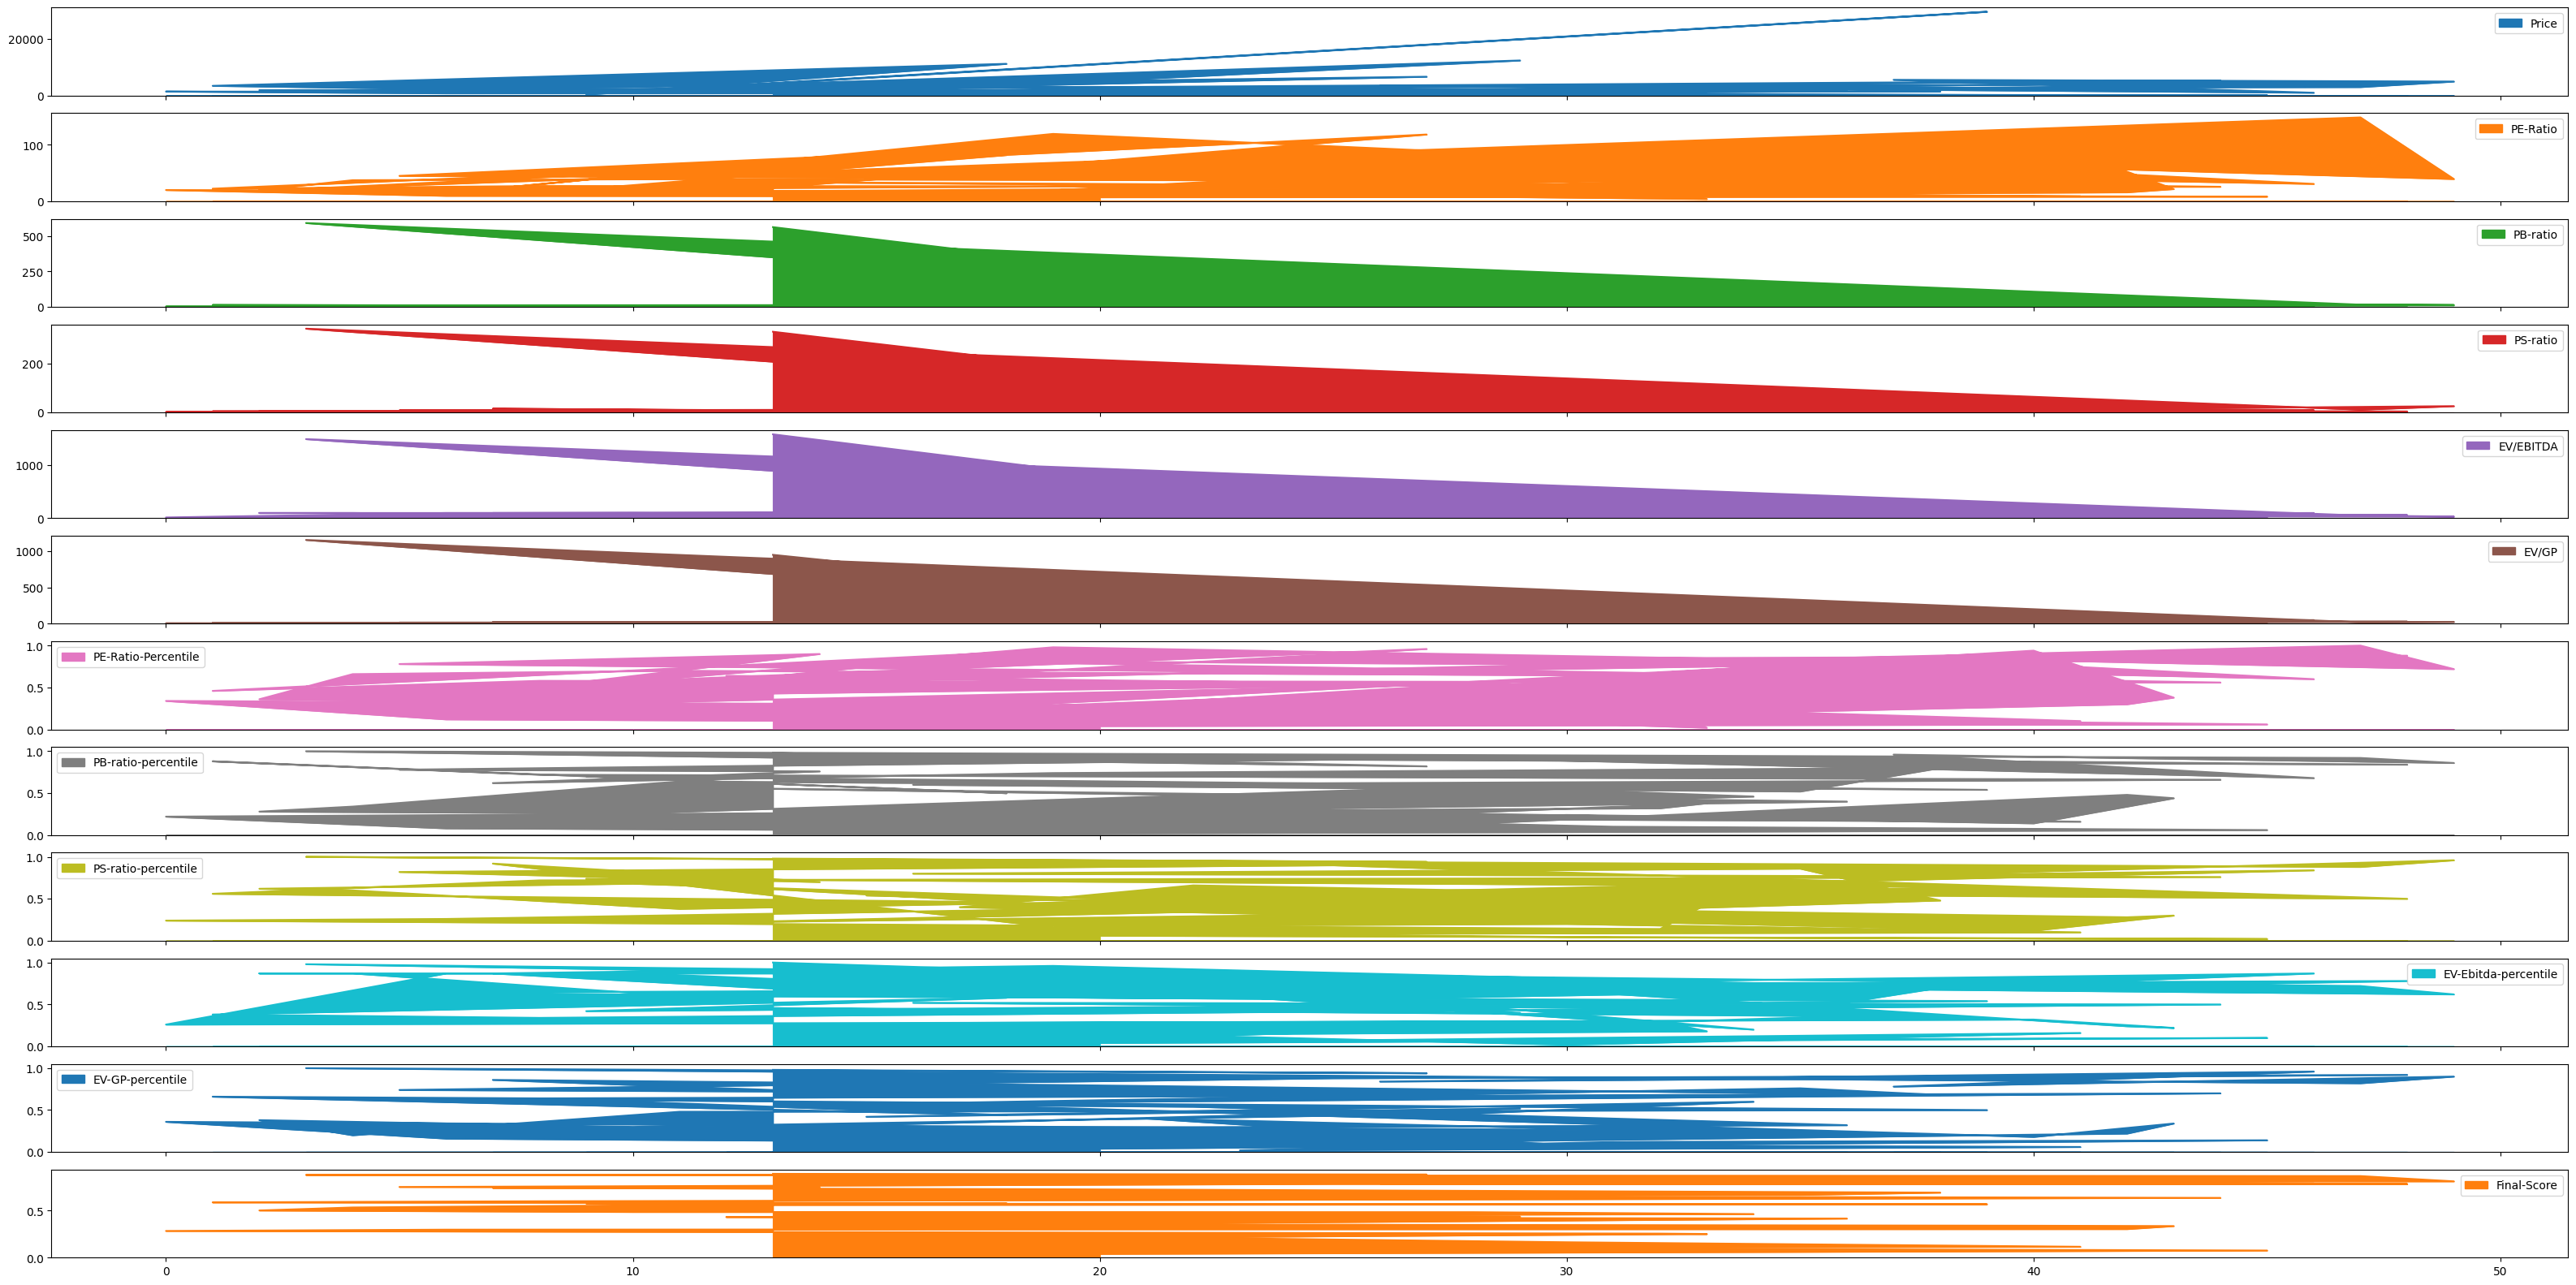

In [16]:
import matplotlib

axs = df.plot.area(figsize=(40,20), subplots=True)
axs